## Lorenz63 System

This notebook evaluates the effectiveness our proposed **KoopSTD** on the well-known Lorenz63 system.

The dataset consists of segments extracted from 500-second simulated trajectories, encompassing five distinct behaviors: line-like, ring-like, Periodic[1-1-2-2], Periodic[1-2], and Chaotic dynamics. For each behavioral type, we include 40 randomly sampled 20-second clips.

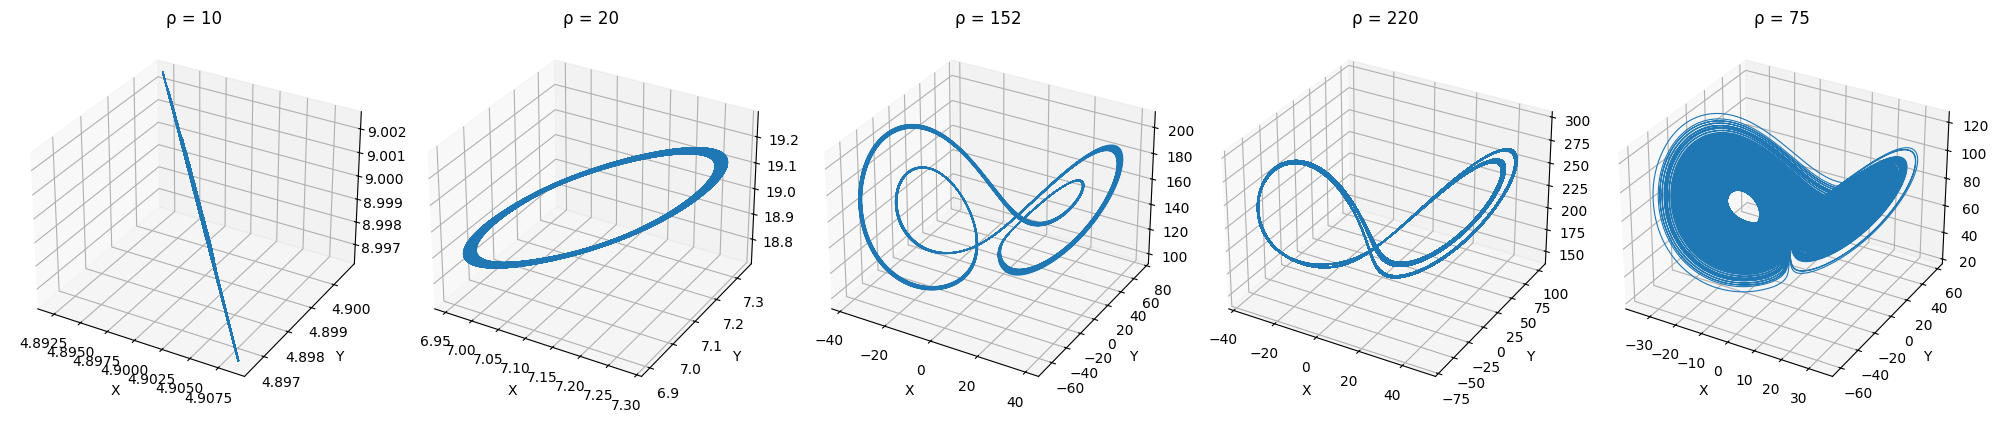

200 (20000, 3)


In [ ]:
from koopstd.dynametric import KoopOpMetric
from koopstd.eval import MetricEvaluator
from koopstd.datasets import Lorenz63
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE, MDS
import pandas as pd

lorenz = Lorenz63(rho_values=[10, 20, 152, 220, 75], num_clips=40)
lorenz.visualize_data(time_range=None)

data = lorenz.data
print(len(data), data[0].shape)

In [2]:
# heatmap for distance matrix and scatter plot for MDS projection

def plot_results(distance_matrix, method_name):
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot heatmap
    sns.heatmap(distance_matrix, cmap='viridis', ax=axes[0])
    lorenz_names = ['Line-like', 'Ring-like', 'Periodic-1122', 'Periodic-11', 'Chaotic']
    axes[0].set_title('KoopSTD Distance Matrix')

    # Set custom tick labels
    tick_positions = [20, 60, 100, 140, 180]  # Middle of each group (40 clips each)
    axes[0].set_xticks(tick_positions)
    axes[0].set_yticks(tick_positions)
    axes[0].set_xticklabels(lorenz_names, rotation=45, ha='right')
    axes[0].set_yticklabels(lorenz_names, rotation=0)

    # Perform MDS for visualization
    vis = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    embedding = vis.fit_transform(distance_matrix)

    # Create DataFrame for scatter plot
    df = pd.DataFrame()
    df["x"] = embedding[:, 0]
    df["y"] = embedding[:, 1]

    # Add labels for different rho values (5 rho values, 40 clips each)
    rho_labels = []
    rho_values = [10, 20, 152, 220, 75]
    for rho in rho_values:
        rho_labels.extend([f"ρ={rho}"] * 40)  # 40 clips per rho value
    df["System"] = rho_labels

    # Plot scatter with improved styling
    sns.scatterplot(data=df, x="x", y="y", hue="System", ax=axes[1], s=80, alpha=0.8)
    axes[1].set_title(f'MDS Projection of Results by {method_name}')
    axes[1].set_xlabel('MDS Component 1')
    axes[1].set_ylabel('MDS Component 2')
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    return plt

### KoopSTD (Ours)

0.9385808751374062


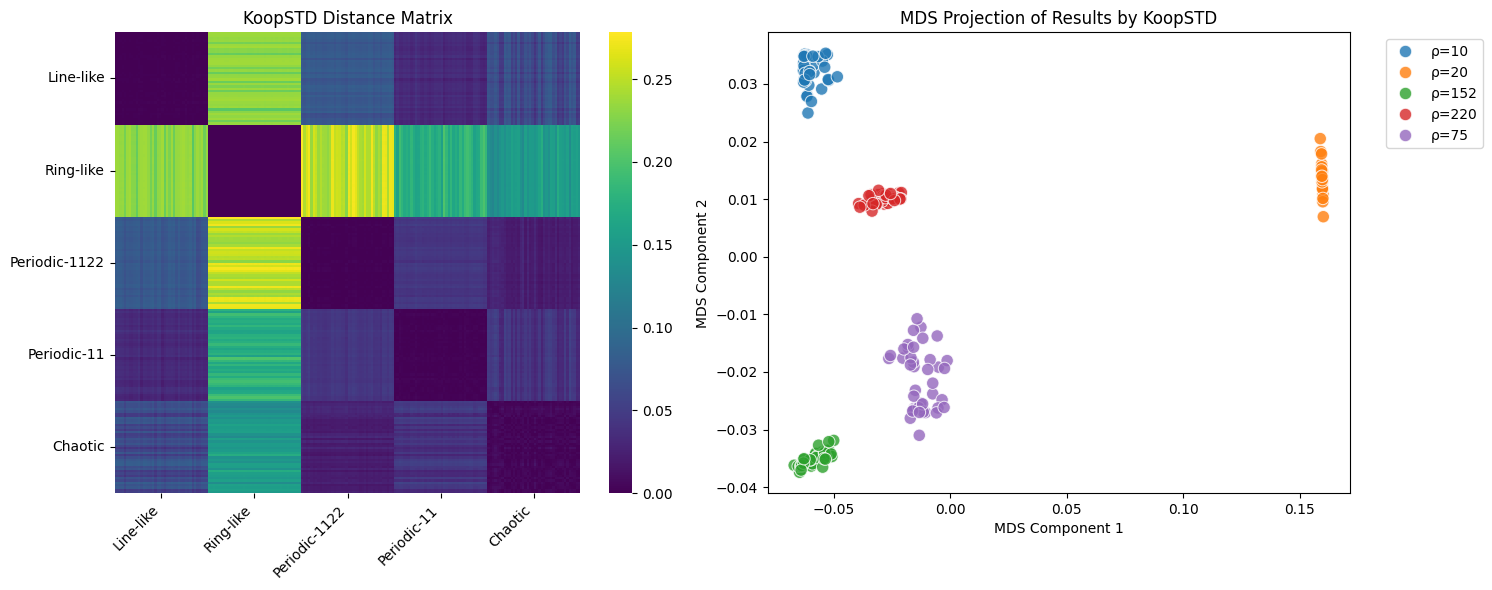

In [6]:
koopstd_params = {'hop_size': 2, 'win_len': 50, 'rank': 8, 'lamb': 0.01}  # hyper-parameters for KoopSTD(l,s,r)
wasserstein_params = {'p': 1, 'method': 'emd', 'feature_type': 'eig'}  # hyper-parameters for Wasserstein distance, either eig or sv is supported

koopstd = KoopOpMetric(X=data, kmd_method='koopstd', kmd_params=koopstd_params, dist='wasserstein', dist_params=wasserstein_params, device='cuda')
koopstd_dist_matrix = koopstd.fit_score()

# Evaluate the performance of KoopSTD by Silhouette Coefficient
me = MetricEvaluator(distance_matrix=koopstd_dist_matrix, cluster_sizes=[40, 40, 40, 40, 40])
silhouette = me.evaluate()
print(silhouette)

plt = plot_results(koopstd_dist_matrix, "KoopSTD")
plt.show()

### HAVOK-based DSA

Next, we evaluate another Koopman operator-based metric for dynamical similarity: **DSA**, proposed by *Ostrow et al., 2024*.

To use the official implementation of DSA, install the package via:

```
pip install dsa-metric
```

The source code can be found at: https://github.com/mitchellostrow/DSA. Due to the high computational time of PAVF in DSA on this large dataset, we also compute the Wasserstein distance between the eigenvalues of the approximated Koopman operator, following the same setup as in KoopSTD. 

0.9815647174821759


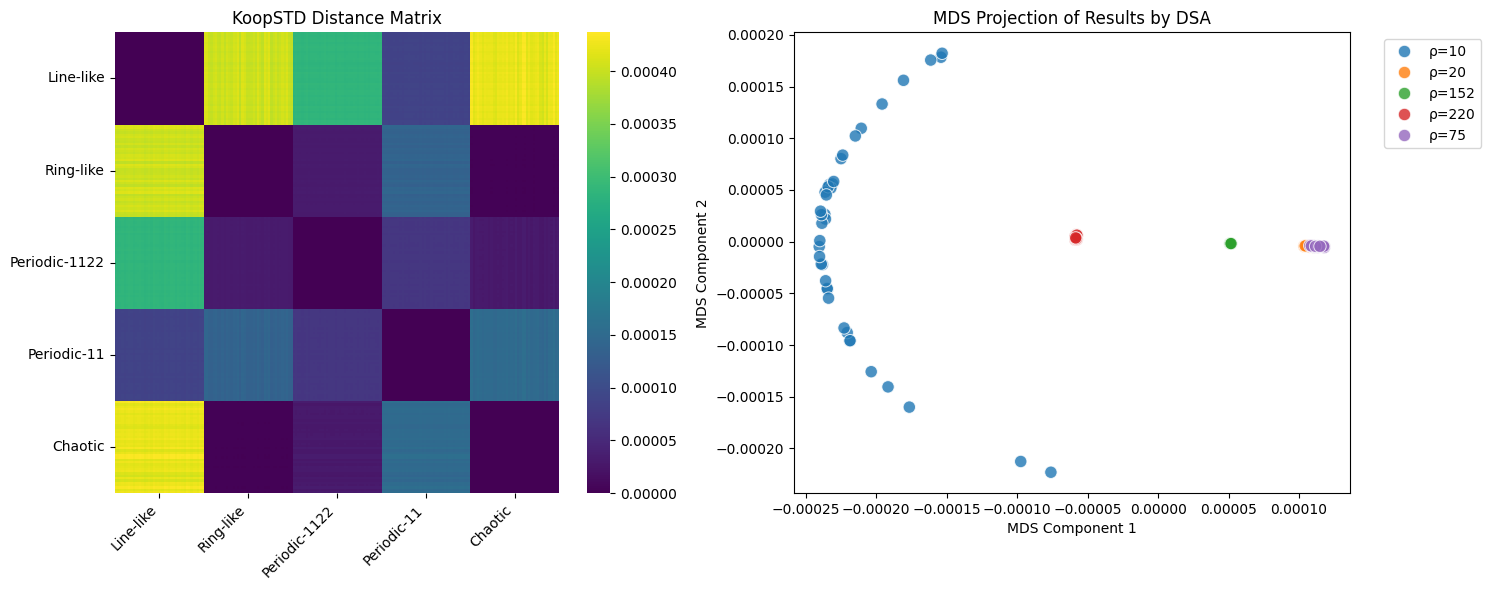

In [7]:
from DSA import DSA

dsa = DSA(data, n_delays=40, rank=10, delay_interval=5, verbose=False, score_method="wasserstein", wasserstein_compare="eig", device="cuda")
dsa_sim = dsa.fit_score()

me = MetricEvaluator(distance_matrix=dsa_sim, cluster_sizes=[40, 40, 40, 40, 40])
silhouette = me.evaluate()
print(silhouette)

plt = plot_results(dsa_sim, "DSA")
plt.show()